<a href="https://colab.research.google.com/github/santhiperbolico/categorical_variables_treatment/blob/main/Embedding_aplicado_a_variables_categ%C3%B3ricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding aplicado a variables categóricas

In [ ]:
!pip install openai lazypredict python-dotenv
#@markdown ## Librerías
#@markdown Ejecuta esta celda para instalar y cargar todas las librerías necesarias
import os
from dotenv import load_dotenv

import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Union

import tensorflow as tf

from lazypredict.Supervised import LazyRegressor, LazyClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.decomposition import PCA


from openai import OpenAI

from google.colab import drive
drive.mount('/content/drive/')

import lazypredict
import xgboost
import lightgbm
import sklearn

MODELS_TYPE = Union[LazyRegressor, LazyClassifier]

lazypredict.Supervised.REGRESSORS = [
    ('XGBRegressor', xgboost.sklearn.XGBRegressor),
    ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor),
    ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
    ('RandomForestRegressor', sklearn.ensemble._forest.RandomForestRegressor),
     ('LinearRegression', sklearn.linear_model._base.LinearRegression),
    ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),

]

lazypredict.Supervised.CLASSIFIERS = [
    ('XGBClassifier', xgboost.sklearn.XGBClassifier),
    ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier),
    ('StackingClassifier', sklearn.ensemble._stacking.StackingClassifier),
    ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
    ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
    ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
    ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
]

def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)


clear_output()
inf('\u2714 Done','success', '50px')

Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

## Introducción
Las variables categóricas son un tipo de variable que representa datos en categorías discretas, como género, país o color. Los modelos de Machine Learning suelen trabajar mejor con datos numéricos, por lo que es necesario convertir estas variables categóricas a un formato que puedan entender. El embedding es una técnica que permite representar variables categóricas como vectores numéricos, lo que facilita su uso en modelos de Machine Learning.

## ¿Qué es el embedding?

El embedding es un proceso que mapea variables categóricas a vectores numéricos de baja dimensionalidad, preservando la información relevante de las categorías. Esto se logra mediante el entrenamiento de un modelo de aprendizaje automático en un conjunto de datos grande. El modelo aprende a representar las categorías como vectores numéricos, donde vectores similares representan categorías similares.

## Ventajas de Usar Embeddings para Variables Categóricas

Dimensionalidad Reducida: Los embeddings permiten representar categorías con un número fijo de dimensiones, lo que es más eficiente que el one-hot encoding, especialmente cuando hay muchas categorías.

Captura de Relaciones Semánticas: Los embeddings pueden capturar similitudes y relaciones entre categorías. Por ejemplo, en un problema de recomendación, podrían aprender que usuarios con comportamientos similares tienen embeddings cercanos.

Mejoras en el Rendimiento: Al usar embeddings, los modelos pueden aprender representaciones más ricas y complejas, lo que puede mejorar el rendimiento predictivo en comparación con técnicas tradicionales.

## Métodos de embedding:

Existen varios métodos para crear embeddings, incluyendo:

- One-hot encoding: Este método crea un vector binario donde cada elemento representa una categoría única.

- Word embedding: Estos modelos se utilizan para representar palabras como vectores numéricos en el procesamiento del lenguaje natural.

- Embedding layers en redes neuronales: Las redes neuronales pueden aprender embeddings de las variables categóricas durante el entrenamiento.

- Métodos de reducción de dimensionalidad: Técnicas como PCA o t-SNE pueden utilizarse para reducir la dimensionalidad de las variables categóricas.

Para demostrar la potencia de los embedding vamos a comparar diferentes metodologías al conjunto de datos `"Home Credit Default Risk"` de Kaggle, en particular la variable `ORGANIZATION_TYPE`. En este ejemplo, demostramos cómo aplicar embeddings a una variable categórica con múltiples valores utilizando y veremos la potencia de este método. Para este ejemplo vamos a utilizar diferentes test estadísticos para medir la información que aportan al problema las diferentes representaciones de variables categóricas:

1. One-Hot Encodding, explicado un poco más arriba.

2. Embedding layers en redes neuronales utilizando keras.

3. Embedding de LLM + PCA para reducir dimensionalidad

Previo a entrar en detalle en estos métodos, veamos un poco primero nuestro conjunto de datos

### Paso 1: Cargar y Preprocesar el Conjunto de Datos

El conjunto de datos "Home Credit Default Risk" de Kaggle está diseñado para ayudar a las instituciones financieras a evaluar la capacidad de un solicitante para pagar un préstamo. Este conjunto de datos contiene información sobre los solicitantes de préstamos, incluyendo datos demográficos, historial de crédito, y características relacionadas con la solicitud y el rendimiento del préstamo.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/adultTrain.csv")
df.columns
df = df.rename(columns={"class": "TARGET"}).drop(columns=["fnlwgt", "education_num"])
label_encoder = LabelEncoder()
df["TARGET"] = label_encoder.fit_transform(df["TARGET"])

model_type = "classifier"
categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                        'relationship', 'race', 'sex', 'native_country']
df.describe(include="all")


,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,TARGET
count,30162.00,30162,30162,30162,30162,30162,30162,30162,30162.00,30162.00,30162.00,30162,30162.00
unique,NaN,7,16,7,14,6,5,2,NaN,NaN,NaN,41,NaN
top,NaN,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,NaN
freq,NaN,22286,9840,14065,4038,12463,25933,20380,NaN,NaN,NaN,27504,NaN
mean,38.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1092.01,88.37,40.93,NaN,0.25
std,13.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7406.35,404.30,11.98,NaN,0.43
min,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,1.00,NaN,0.00
25%,28.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,40.00,NaN,0.00
50%,37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,40.00,NaN,0.00
75%,47.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,45.00,NaN,0.00


In [ ]:
url = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/video_games_sales.csv"

df = pd.read_csv(url)

columns = ["Name", "Platform", "Year_of_Release", "Genre", "Publisher", "Global_Sales", "User_Score"]
df = df[columns]
df = df[~df.isna().any(axis=1)]
(df["User_Score"] == "tbd").sum()
publishers = df.Publisher.value_counts()
others_publishers = publishers[publishers <= 150]
df.loc[df.Publisher.isin(others_publishers.index) ,"Publisher"] = "Other"
df.Year_of_Release = df.Year_of_Release.astype(int)
df["years"] = df.Year_of_Release.apply(lambda x: f"dec_{x - x % 10}")
df = df.rename(columns={"User_Score": "TARGET"})
df = df[["Platform", "years", "Genre", "Publisher", "Global_Sales", "TARGET"]]
df_val = df[df["TARGET"] == "tbd"]
df = df[~(df["TARGET"] == "tbd")]
df.TARGET = df.TARGET.astype(float) / 10

model_type = "regressor"
categorical_features = ["Platform", "years", "Genre", "Publisher"]
df.describe(include="all")

,Platform,years,Genre,Publisher,Global_Sales,TARGET
count,7461,7461,7461,7461,7461.00,7461.00
unique,17,4,12,18,NaN,NaN
top,PS2,dec_2000,Action,Other,NaN,NaN
freq,1220,4872,1796,2209,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.74,0.71
std,NaN,NaN,NaN,NaN,1.89,0.15
min,NaN,NaN,NaN,NaN,0.01,0.00
25%,NaN,NaN,NaN,NaN,0.11,0.64
50%,NaN,NaN,NaN,NaN,0.28,0.75
75%,NaN,NaN,NaN,NaN,0.72,0.82


In [ ]:
# Cargar el conjunto de datos (disponible en Kaggle: <https://www.kaggle.com/c/home-credit-default-risk/data)>
url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(url)
# Renombrar las columnas para claridad en el ejemplo
df = df.rename(columns=dict(zip(['ocean_proximity', 'median_house_value'], ['ORGANIZATION_TYPE', 'TARGET'])))

# Eliminamos las variables de longitud y latitude
df = df.drop(columns=["longitude", "latitude"])
categorical_features = ["ORGANIZATION_TYPE"]
model_type = "regressor"

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  20640 non-null  float64
 1   total_rooms         20640 non-null  float64
 2   total_bedrooms      20433 non-null  float64
 3   population          20640 non-null  float64
 4   households          20640 non-null  float64
 5   median_income       20640 non-null  float64
 6   TARGET              20640 non-null  float64
 7   ORGANIZATION_TYPE   20640 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.3+ MB


None

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY
...,...,...,...,...,...,...,...,...
20635,25.00,1665.00,374.00,845.00,330.00,1.56,78100.00,INLAND
20636,18.00,697.00,150.00,356.00,114.00,2.56,77100.00,INLAND
20637,17.00,2254.00,485.00,1007.00,433.00,1.70,92300.00,INLAND
20638,18.00,1860.00,409.00,741.00,349.00,1.87,84700.00,INLAND


Para ver el estado inicial del problema podemos entrenar una regresión lineal y analizar su error. Pero primero, observamos que el dataset tiene datos nulos en la columna `total_bedrooms`, optamos por eliminar aquellos registros que contengan algún dato nulo.

In [ ]:
# Eliminar aquellas filas con algún dato nulo.
df =df[~df.isna().any(axis=1)]
display(df.head())



def get_lazy_model(type_name: str) -> MODELS_TYPE:
  TYPE_PROBLEM = {
      "regressor": LazyRegressor(
          verbose=0,
          ignore_warnings=False,
          custom_metric=mean_absolute_percentage_error
          ),
      "classifier": LazyClassifier(verbose=0,
          ignore_warnings=False)
  }
  try:
    return TYPE_PROBLEM[type_name]
  except KeyError:
    raise ValueError("Error en el tipo Lazy")




def evaluate_dataset(df: pd.DataFrame, sample_size: int = None, type_model: str = "regressor") -> pd.DataFrame:
  # Seleccionar una muestra aleatoria de 2000 filas
  # Dividir el conjunto de datos en entrenamiento y prueba
  np.random.seed(123456789)
  df_models = df.copy()
  if sample_size:
    df_models = df.sample(sample_size)
  X = df_models.drop(columns=["TARGET"])
  y = df_models['TARGET'].values
  scaler = MinMaxScaler()
  scaler_y = MinMaxScaler()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Entrenar un modelo de regresión lineal
  cols_to_scaler = [col for col in X_train.columns if not "embed_" in col]
  X_train[cols_to_scaler] = scaler.fit_transform(X_train[cols_to_scaler])
  X_test[cols_to_scaler] = scaler.transform(X_test[cols_to_scaler])
  reg = get_lazy_model(type_model)
  models,predictions = reg.fit(X_train, X_test, y_train, y_test)
  return models

display(evaluate_dataset(df.drop(columns=categorical_features), type_model=model_type))

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY


 17%|█▋        | 1/6 [00:00<00:01,  3.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 6
[LightGBM] [Info] Start training from score 206644.400098


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
LGBMRegressor,0.69,0.69,65386.92,0.26,0.29
HistGradientBoostingRegressor,0.69,0.69,65575.26,0.72,0.29
RandomForestRegressor,0.67,0.67,67145.71,11.44,0.29
XGBRegressor,0.67,0.67,67294.40,0.31,0.29
LinearRegression,0.57,0.57,76587.33,0.04,0.35
BayesianRidge,0.57,0.57,76588.48,0.06,0.35


### One-Hot Encoding

In [ ]:
df_one_hot = df.copy().drop(columns=categorical_features)
df_one_hot = pd.concat((df_one_hot, pd.get_dummies(df[categorical_features]).astype(int)), axis=1)
display(df_one_hot.head())

evaluate_dataset(df_one_hot, type_model=model_type)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE_<1H OCEAN,ORGANIZATION_TYPE_INLAND,ORGANIZATION_TYPE_ISLAND,ORGANIZATION_TYPE_NEAR BAY,ORGANIZATION_TYPE_NEAR OCEAN
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,0,0,0,1,0
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,0,0,0,1,0
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,0,0,0,1,0
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,0,0,0,1,0
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,0,0,0,1,0


 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 10
[LightGBM] [Info] Start training from score 206644.400098


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
LGBMRegressor,0.73,0.73,60208.57,0.45,0.24
HistGradientBoostingRegressor,0.73,0.73,60384.26,1.19,0.24
RandomForestRegressor,0.72,0.72,61560.89,11.39,0.24
XGBRegressor,0.72,0.72,62050.15,0.84,0.25
LinearRegression,0.64,0.64,70322.01,0.04,0.29
BayesianRidge,0.64,0.64,70323.89,0.10,0.29


## Label Encoder

In [ ]:
# Codificar las categorías
label_encoder = LabelEncoder()
df_encoder = df.copy().drop(columns=categorical_features)
for col in categorical_features:
  df_encoder[f"{col}_COD"] = label_encoder.fit_transform(df[col])
display(df_encoder.head())

evaluate_dataset(df_encoder, type_model=model_type)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE_COD
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,3
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,3
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,3
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,3
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,3


 17%|█▋        | 1/6 [00:00<00:01,  3.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 7
[LightGBM] [Info] Start training from score 206644.400098


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
LGBMRegressor,0.73,0.73,60433.03,0.27,0.24
HistGradientBoostingRegressor,0.73,0.73,60664.40,0.64,0.24
RandomForestRegressor,0.72,0.72,62334.63,11.75,0.25
XGBRegressor,0.71,0.71,62533.22,0.32,0.25
LinearRegression,0.57,0.58,76208.99,0.03,0.34
BayesianRidge,0.57,0.58,76210.16,0.03,0.34


## Keras Embedding

In [ ]:
# Codificar las categorías
label_encoder = LabelEncoder()
df_embedding = df.copy().drop(columns=categorical_features)
categorical_features_cod = []
for col in categorical_features:
  df_embedding[f"{col}_COD"] = label_encoder.fit_transform(df[col])
  categorical_features_cod.append(f"{col}_COD")


def generate_embedding_model(
    df_data: pd.DataFrame,
    categorical_features,
    size_embedding: list[int] = None,
    model_type: str = "regressor"
    ):

  np.random.seed(1234)
  models = []
  inputs = []

  activation_output = "relu"
  loss_function = "mse"
  if model_type == "classifier":
    activation_output = "sigmoid"
    loss_function = "binary_crossentropy"

  if size_embedding is None:
    size_embedding = [None] * len(categorical_features)

  if isinstance(size_embedding, int):
    size_embedding = [size_embedding] * len(categorical_features)

  # Crea los embedding para cada variable categorica
  k = 0
  for k, cat in enumerate(categorical_features):
      n_features = df_data[cat].unique().size
      n_embedding = n_features
      if size_embedding[k]:
        n_embedding = size_embedding[k]

      vocab_size = df_data[cat].nunique()
      inpt = tf.keras.layers.Input(shape=(1,), name='input_' + cat)
      embed = tf.keras.layers.Embedding(vocab_size, n_embedding, trainable=True,
                                        embeddings_initializer=tf.initializers.random_normal)(inpt)
      embed_reshaped = tf.keras.layers.Reshape(target_shape=(n_embedding,))(embed)
      if n_embedding > n_features:
        embed_reshaped = tf.keras.layers.Dense(n_features)(embed_reshaped)
      models.append(embed_reshaped)
      inputs.append(inpt)


  merge_models = tf.keras.layers.concatenate(models)
  pre_preds = tf.keras.layers.Dense(1000)(merge_models)
  pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
  pre_preds = tf.keras.layers.Dense(500)(pre_preds)
  pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
  pred = tf.keras.layers.Dense(1, activation=activation_output)(pre_preds)

  model_embedding = tf.keras.models.Model(inputs=inputs, outputs=merge_models)
  model_full = tf.keras.models.Model(inputs=inputs, outputs=pred)

  model_full.compile(optimizer='adam', loss=loss_function)

  return model_full, model_embedding

# Construimos una red neuronal que construya el embedding
train_size = int(df_embedding.shape[0] * 0.80)
df_train = df_embedding.iloc[:train_size, :]
df_test = df_embedding.iloc[train_size:, :]

model_full, model_embedding = generate_embedding_model(df_embedding, categorical_features_cod, model_type=model_type)

scaler_x = MinMaxScaler()
input_num_train = scaler_x.fit_transform(df_train.drop(columns=categorical_features_cod + ["TARGET"]))
input_num_test = scaler_x.transform(df_test.drop(columns=categorical_features_cod + ["TARGET"]))

labels_train = df_train["TARGET"].values
labels_test = df_test["TARGET"].values

input_dict_train = {}
input_dict_test = {}
input_embedding = {}
cols_embeddings = []

for col in categorical_features_cod:
  input_dict_train[f"input_{col}"] = df_train[col].values
  input_dict_test[f"input_{col}"] = df_test[col].values
  input_embedding.update({f"input_{col}":  df_embedding[col].values})
  n_features = df_embedding[col].nunique()
  cols_embeddings += [f'{col}_embed_{i}' for i in range(n_features)]

# Añadir características numéricas
input_dict_train["input_number_features"] = input_num_train
input_dict_test["input_number_features"] = input_num_test

history = model_full.fit(
    input_dict_train,
    labels_train,
    epochs=20,
    batch_size=64,
    validation_data=(input_dict_test, labels_test),
    verbose=1
)


# Obtener los embeddings
embeddings = model_embedding.predict(input_embedding)
embeddings_df = pd.DataFrame(embeddings, columns=cols_embeddings).reset_index(drop=True)
df_embedding = df_embedding.drop(columns=categorical_features_cod).reset_index(drop=True)
df_embedding = pd.concat((df_embedding, embeddings_df), axis=1)

display(df_embedding.head())

evaluate_dataset(df_embedding, type_model=model_type)


Epoch 1/20
256/256 [==============================] - 8s 15ms/step - loss: 53762191360.0000 - val_loss: 65462951936.0000
Epoch 2/20
256/256 [==============================] - 4s 15ms/step - loss: 53720150016.0000 - val_loss: 65427107840.0000
Epoch 3/20
256/256 [==============================] - 5s 20ms/step - loss: 53602570240.0000 - val_loss: 65276215296.0000
Epoch 4/20
256/256 [==============================] - 4s 17ms/step - loss: 53382496256.0000 - val_loss: 65060909056.0000
Epoch 5/20
256/256 [==============================] - 4s 15ms/step - loss: 52858925056.0000 - val_loss: 64220377088.0000
Epoch 6/20
256/256 [==============================] - 4s 15ms/step - loss: 52252708864.0000 - val_loss: 63781027840.0000
Epoch 7/20
256/256 [==============================] - 6s 22ms/step - loss: 51716550656.0000 - val_loss: 63338188800.0000
Epoch 8/20
256/256 [==============================] - 4s 15ms/step - loss: 51155218432.0000 - val_loss: 62751145984.0000
Epoch 9/20
256/256 [============

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE_COD_embed_0,ORGANIZATION_TYPE_COD_embed_1,ORGANIZATION_TYPE_COD_embed_2,ORGANIZATION_TYPE_COD_embed_3,ORGANIZATION_TYPE_COD_embed_4
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,0.01,-0.08,-0.08,-0.06,-0.01
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,0.01,-0.08,-0.08,-0.06,-0.01
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,0.01,-0.08,-0.08,-0.06,-0.01
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,0.01,-0.08,-0.08,-0.06,-0.01
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,0.01,-0.08,-0.08,-0.06,-0.01


 17%|█▋        | 1/6 [00:01<00:08,  1.61s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 11
[LightGBM] [Info] Start training from score 206644.400098


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
LGBMRegressor,0.73,0.74,60138.03,0.46,0.24
HistGradientBoostingRegressor,0.73,0.74,60194.57,1.74,0.24
RandomForestRegressor,0.72,0.72,61696.80,11.88,0.24
XGBRegressor,0.72,0.72,62302.24,1.61,0.24
BayesianRidge,0.64,0.64,70250.57,0.08,0.29
LinearRegression,0.64,0.64,70322.01,0.04,0.29


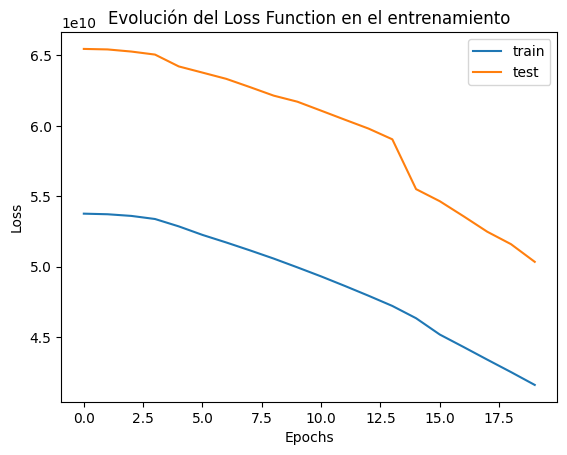

In [ ]:
plt.title("Evolución del Loss Function en el entrenamiento")
plt.plot(history.epoch, history.history["loss"], label="train")
plt.plot(history.epoch, history.history["val_loss"], label="test")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## LLM Embedding

In [ ]:
#@markdown Indica el archivo con la variable de entorno "API_KEY" de OpenAI.
env_file = "/content/drive/MyDrive/vimana_test_embeding/env_embedding" #@param

if env_file == "":
  load_dotenv()
else:
  load_dotenv(env_file)

params = {
  "api_key": os.getenv("API_KEY")
}

def create_embedding(client: OpenAI, values: np.ndarray, col_name: str) -> pd.DataFrame:
  embedding_list = []
  for val in values:
    response = client.embeddings.create(
      input=f"{col_name}: {val}",
      model="text-embedding-3-small"
    )
    embedding = response.data[0].embedding
    print(f" Embedding {val}")
    print(f"\t -Data Len {len(response.data)}")
    print(f"\t -Embedding Shape {len(embedding)}")
    embedding_list.append(embedding)

  df_data = pd.DataFrame(np.array(embedding_list), index=values)
  return df_data


def get_new_base(df_data: pd.DataFrame) -> np.ndarray:
  pca = PCA(n_components=np.linalg.matrix_rank(df_data))
  return pca.fit_transform(df_data)

def get_distance_matrix(df_data: pd.DataFrame) -> np.ndarray:
  distance = np.zeros((df_data.shape[0], df_data.shape[0]))
  for i in range(distance.shape[0]):
    vector = df_data.iloc[i, :]
    for j in range(distance.shape[1]):
      distance[i,j] = np.linalg.norm(vector - df_data.iloc[j, :])
  return distance



In [ ]:
client = OpenAI(api_key=params.get("api_key"))
df_llm_embedding = df.copy()

for col in categorical_features:
  df_col = create_embedding(client, df[col].unique(), col_name=col)
  pca_embedding = pd.DataFrame(get_new_base(df_col), index=df_col.index)
  pca_embedding.columns = [f"{col}_embed_{i}" for i in pca_embedding.columns]
  pca_embedding.index.name = col
  df_llm_embedding = pd.merge(df, pca_embedding.reset_index(), on=col)


df_llm_embedding = df_llm_embedding.drop(columns=categorical_features)
display(df_llm_embedding)
evaluate_dataset(df_llm_embedding, type_model=model_type)

 Embedding NEAR BAY
	 -Data Len 1
	 -Embedding Shape 1536
 Embedding <1H OCEAN
	 -Data Len 1
	 -Embedding Shape 1536
 Embedding INLAND
	 -Data Len 1
	 -Embedding Shape 1536
 Embedding NEAR OCEAN
	 -Data Len 1
	 -Embedding Shape 1536
 Embedding ISLAND
	 -Data Len 1
	 -Embedding Shape 1536


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,TARGET,ORGANIZATION_TYPE_embed_0,ORGANIZATION_TYPE_embed_1,ORGANIZATION_TYPE_embed_2,ORGANIZATION_TYPE_embed_3,ORGANIZATION_TYPE_embed_4
0,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,0.50,-0.18,0.09,-0.12,0.00
1,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,0.50,-0.18,0.09,-0.12,0.00
2,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,0.50,-0.18,0.09,-0.12,0.00
3,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,0.50,-0.18,0.09,-0.12,0.00
4,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,0.50,-0.18,0.09,-0.12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
20428,27.00,1675.00,521.00,744.00,331.00,2.16,450000.00,-0.27,-0.00,0.40,0.04,0.00
20429,52.00,2359.00,591.00,1100.00,431.00,2.83,414700.00,-0.27,-0.00,0.40,0.04,0.00
20430,52.00,2127.00,512.00,733.00,288.00,3.39,300000.00,-0.27,-0.00,0.40,0.04,0.00
20431,52.00,996.00,264.00,341.00,160.00,2.74,450000.00,-0.27,-0.00,0.40,0.04,0.00


 17%|█▋        | 1/6 [00:00<00:01,  2.52it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 11
[LightGBM] [Info] Start training from score 207282.923957


100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
HistGradientBoostingRegressor,0.73,0.73,59814.84,0.67,0.24
LGBMRegressor,0.73,0.73,60040.61,0.30,0.24
XGBRegressor,0.72,0.72,61042.42,0.40,0.24
RandomForestRegressor,0.71,0.71,61549.09,17.43,0.25
BayesianRidge,0.62,0.62,70463.48,0.03,0.29
LinearRegression,0.62,0.62,70464.73,0.03,0.29
